<a href="https://colab.research.google.com/github/arshpreetsingh134/Social-Distancing-Tool/blob/master/social_dist_tool.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [78]:
!pip install -U torch==1.5 torchvision==0.6 -f https://download.pytorch.org/whl/cu101/torch_stable.html 
# We used cu101 here because Google Colab supports CUDA 10.1

!nvcc --version

!pip install cython pyyaml==5.1

# COCO is a large image dataset designed for object detection, segmentation, person keypoints detection, stuff segmentation, etc.
# This package provides Python APIs that assists in loading, parsing, and visualizing the annotations in COCO. Here, we will be 
# installing this package from GitHub.

!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

!gcc --version


# Installing Detectron2: An open-source library for object detection and segmentation created by the Facebook AI Research team (FAIR)

!pip install detectron2==0.1.3 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.5/index.html

Looking in links: https://download.pytorch.org/whl/cu101/torch_stable.html
Requirement already up-to-date: torch==1.5 in /usr/local/lib/python3.6/dist-packages (1.5.0+cu101)
Requirement already up-to-date: torchvision==0.6 in /usr/local/lib/python3.6/dist-packages (0.6.0+cu101)
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2019 NVIDIA Corporation
Built on Sun_Jul_28_19:07:16_PDT_2019
Cuda compilation tools, release 10.1, V10.1.243
  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-6a7n7ufq
  Running command git clone -q https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-6a7n7ufq
  Created wheel for pycocotools: filename=pycocotools-2.0-cp36-cp36m-linux_x86_64.whl size=267013 sha256=e74c9c4d92a533b8975897c24e2797f9fcd89c7e567361b1ca9d78ae383d59de
  Stored in directory: /tmp/pip-ephem-wheel-cache-ur4me7xt/wheels/90/51/41/646daf401c3bc408ff10de34ec76587a9b3ebfac8d21ca5c3a
Successfully built pycocotools
  Found existing installation: pycocotool

1.5.0+cu101 True
gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.

Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.5/index.html


In [0]:
### Import libraries ###

import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# Import some common libraries

import numpy as np
import cv2
import random
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt

# Import some common utilities from Detectron2

from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog

In [80]:
### Read a video and save frames to a folder ###

%%time
!rm -r frames/*
!mkdir frames/

#specify path to video
video = "/content/drive/My Drive/sample.mp4"

#capture video
cap = cv2.VideoCapture(video)
cnt=0

# Check if video file is opened successfully
if (cap.isOpened()== False): 
  print("Error opening video stream or file")

ret,first_frame = cap.read()

#Read until video is completed
while(cap.isOpened()):
    
  # Capture frame-by-frame
  ret, frame = cap.read()
     
  if ret == True:

    #save each frame to folder        
    cv2.imwrite('frames/'+str(cnt)+'.png', frame)
    cnt=cnt+1
    if(cnt==750):
      break

  # Break the loop
  else: 
    break

mkdir: cannot create directory ‘frames/’: File exists
CPU times: user 1min 9s, sys: 2.77 s, total: 1min 12s
Wall time: 1min 13s


In [81]:
## Checking the Frame Rate of a video ##

FPS= cap.get(cv2.CAP_PROP_FPS)
print(FPS)

25.0


In [0]:
## Downloading the pre-trained model for Object Detection from Detectron2’s Model Zoo.

cfg = get_cfg()

cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_C4_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.9  # set threshold for this model

# Finding a model from Detectron2's Model Zoo.
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_C4_3x.yaml")
predictor = DefaultPredictor(cfg)

In [0]:
###  Now, we read a random image & pass it to the model for predictions  ###

img = cv2.imread("frames/30.png")

outputs = predictor(img)

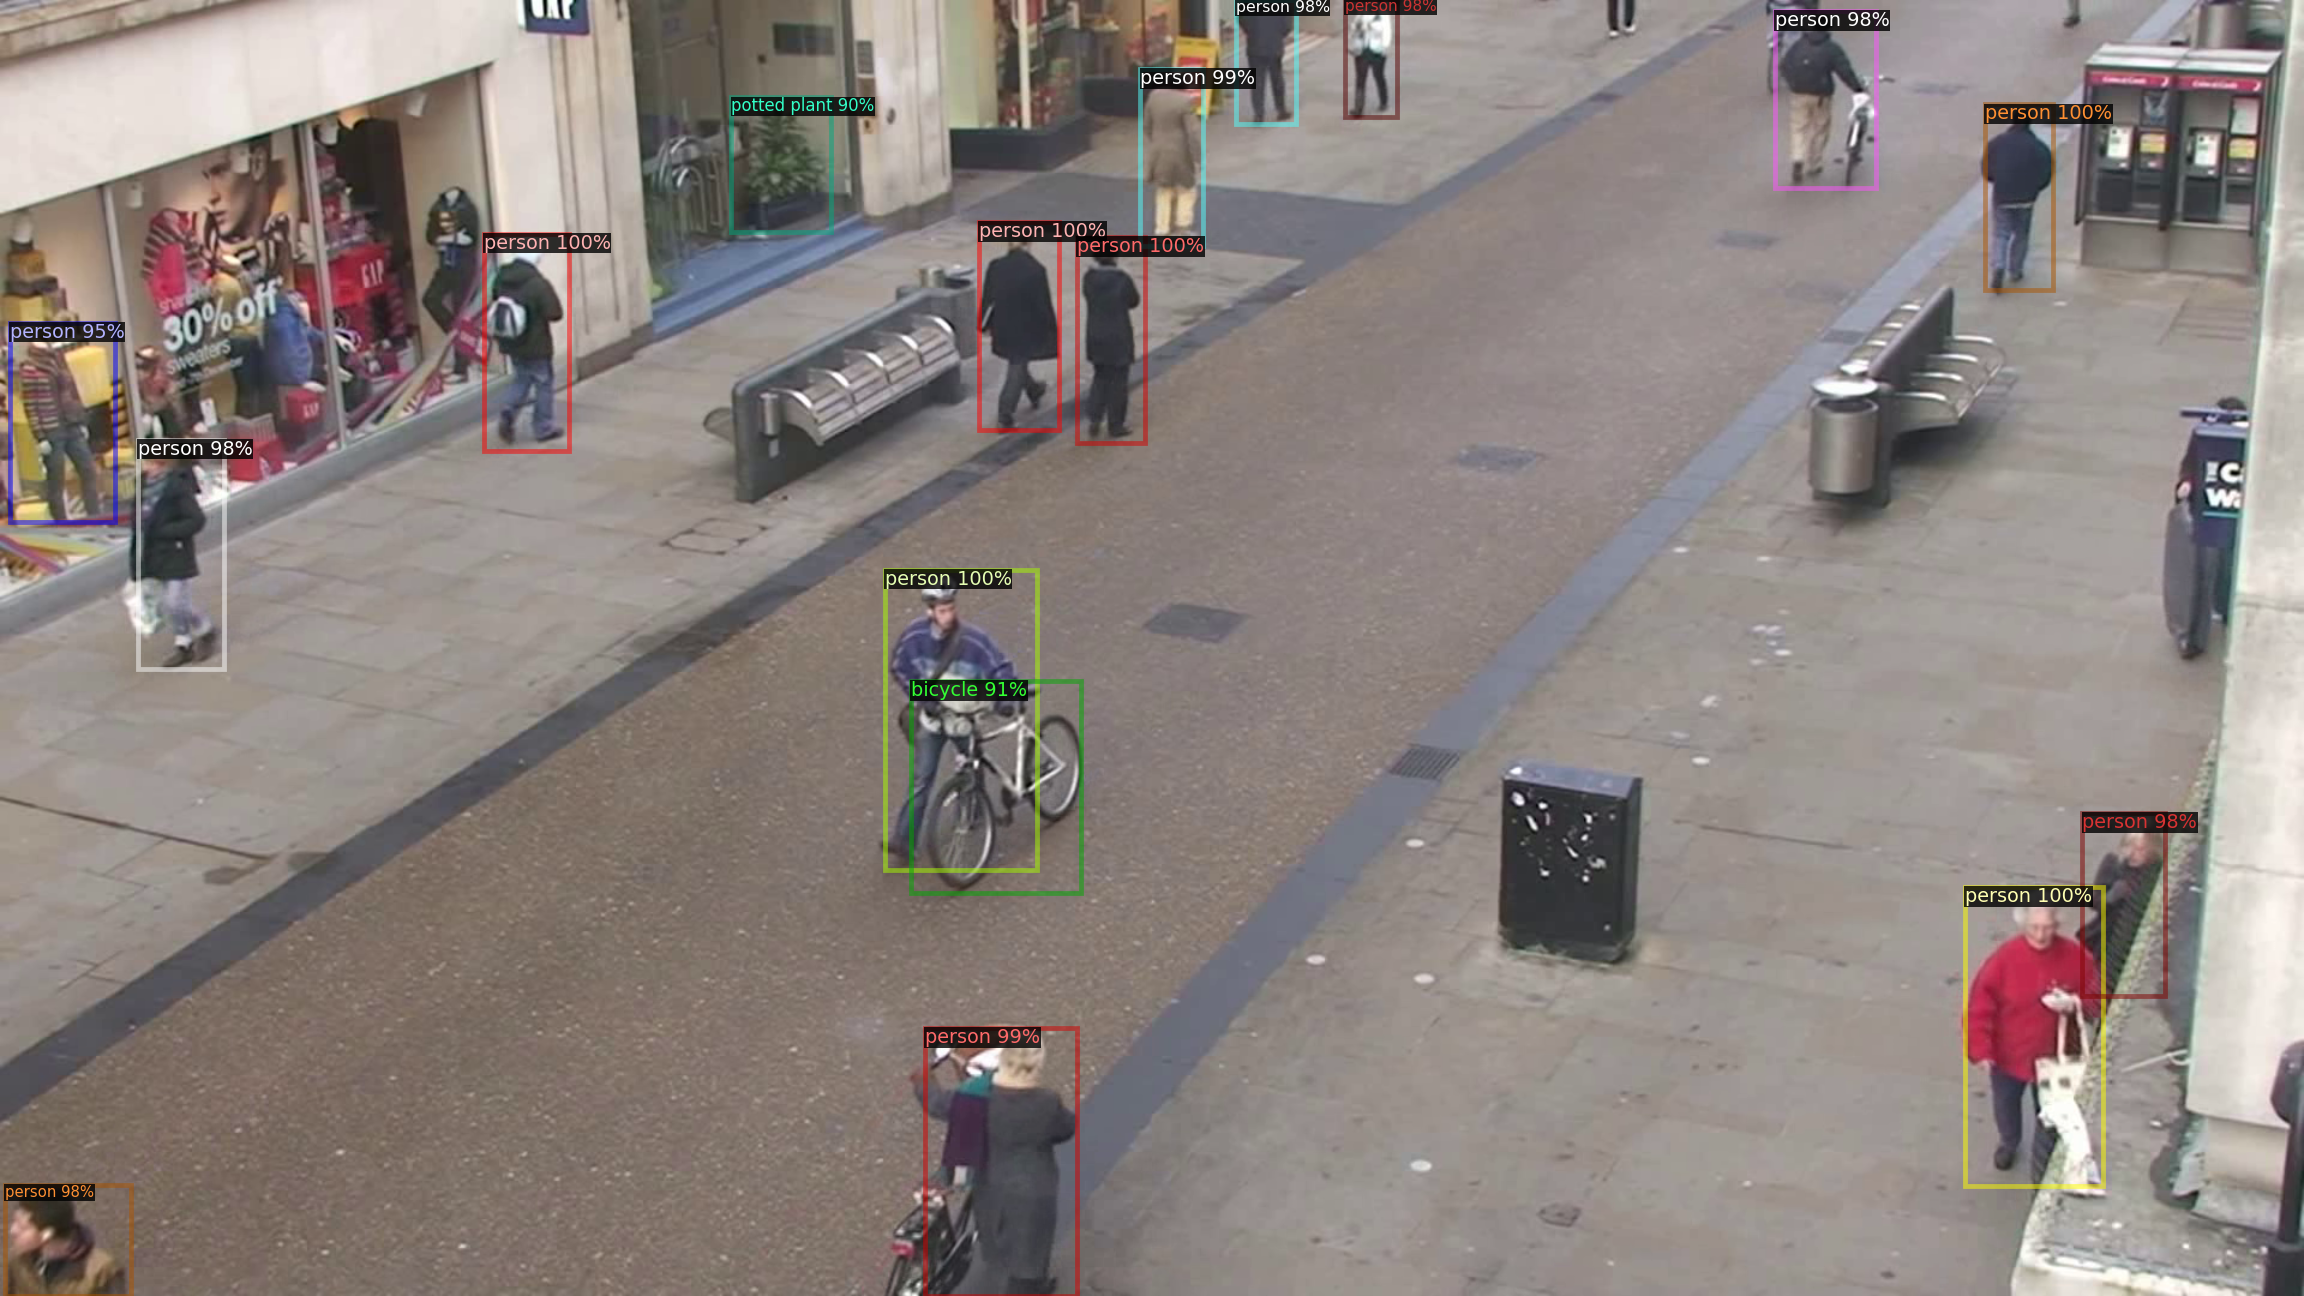

In [84]:
# We use `Visualizer` to draw the predictions on the image.
v = Visualizer(img[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(v.get_image()[:, :, ::-1])

In [85]:
# Understanding the objects present in an image
classes=outputs['instances'].pred_classes.cpu().numpy()
print(classes)

[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1 58]


In [86]:
# Understanding the bounding boxes of an object
bbox = outputs['instances'].pred_boxes.tensor.cpu().numpy()
print(bbox)

[[8.97625732e+02 1.98114746e+02 9.54295410e+02 3.69938965e+02]
 [8.15539734e+02 1.85776901e+02 8.82243225e+02 3.58775452e+02]
 [7.37155396e+02 4.75216461e+02 8.64526550e+02 7.25281311e+02]
 [1.63727197e+03 7.39270691e+02 1.75216077e+03 9.88613037e+02]
 [4.02958832e+02 1.95546738e+02 4.74301331e+02 3.76508423e+02]
 [1.65389941e+03 8.78322067e+01 1.71117517e+03 2.42416138e+02]
 [9.50240295e+02 5.83510170e+01 1.00226202e+03 2.05864594e+02]
 [7.70899780e+02 8.57066711e+02 8.97423645e+02 1.08000000e+03]
 [1.14824608e+02 3.66958679e+02 1.86961517e+02 5.57881104e+02]
 [3.88901186e+00 9.87568298e+02 1.09564430e+02 1.08000000e+03]
 [1.73523938e+03 6.77691223e+02 1.80430774e+03 8.29950134e+02]
 [1.12059485e+03 0.00000000e+00 1.16453687e+03 9.86647034e+01]
 [1.47889429e+03 1.01930275e+01 1.56364978e+03 1.57773270e+02]
 [1.02976807e+03 1.21370912e+00 1.07966443e+03 1.04322639e+02]
 [8.13119888e+00 2.69681549e+02 9.55819016e+01 4.35993988e+02]
 [7.59207336e+02 5.68076111e+02 9.01112183e+02 7.441908

In [87]:
# Identifying classes and bounding boxes related to only people.

#Identify persons
per = np.where(classes==0)[0]

#Locate the boxes
person = bbox[per]

#Total no. of persons
num = len(person)

print(num)

15


In [88]:
# Format of the Bounding Box
(x1, y1, x2, y2) = person[0]
print(x1, y1, x2, y2)

897.62573 198.11475 954.2954 369.93896


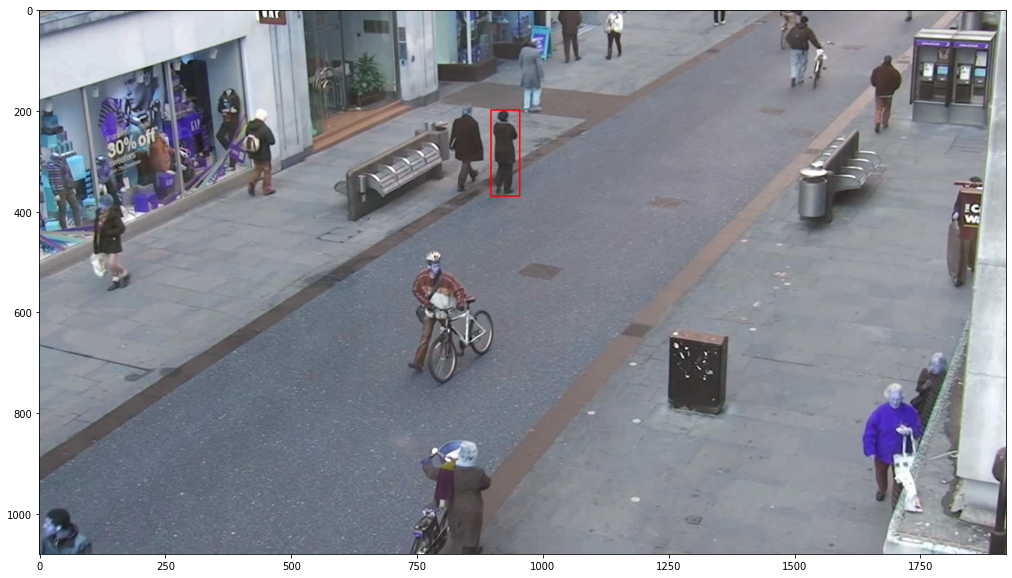

In [89]:
# Let us verify by drawing a bounding box over one of the persons.
img = cv2.imread('frames/30.png')
_ = cv2.rectangle(img, (x1, y1), (x2, y2), (255,0,0), 2)

plt.figure(figsize=(20,10))
plt.imshow(img)

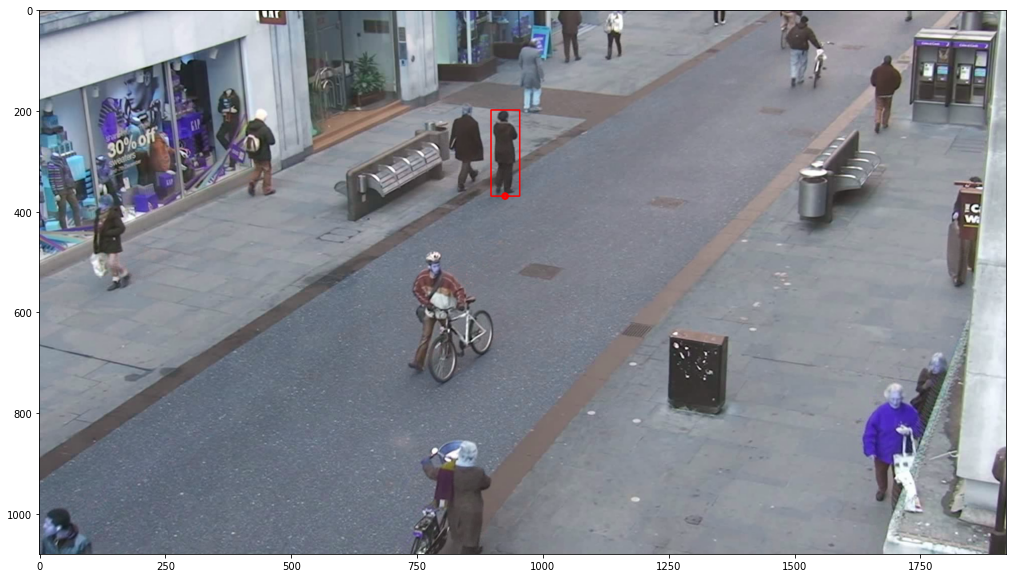

In [90]:
#Compute center of image
x_center = int((x1+x2)/2)
y_center = int(y2)

center = (x_center, y_center)

_=cv2.circle(img, center, 5, (255,0,0), 3)

plt.figure(figsize=(20,10))
plt.imshow(img)

In [0]:
# Defining a function that returns the bottom center of every block.

def mid_cal(img, person, ind):
  x1,y1,x2,y2 = person[ind]
  _ = cv2.rectangle(img, (x1, y1), (x2, y2), (0,0,255), 2)

  x_mid = int((x1+x2)/2)
  y_mid = int(y2)
  mid = (x_mid,y_mid)

  _= cv2.circle(img, mid, 5, (0,0,255), -1)
  cv2.putText(img, str(ind), mid, cv2.FONT_HERSHEY_SIMPLEX,1, (255, 255, 255), 2, cv2.LINE_AA)

  return mid

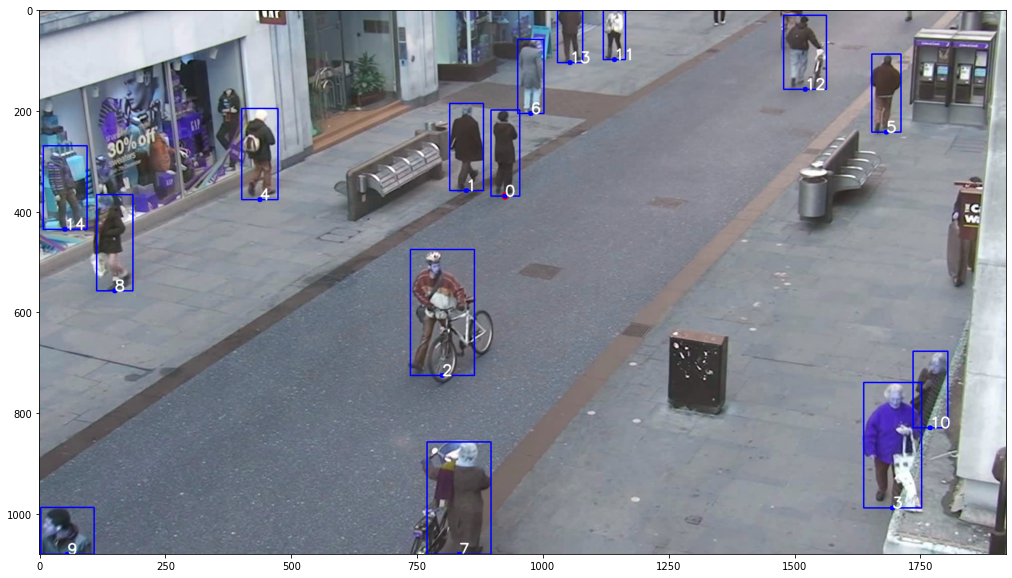

In [92]:
# Calling the function

mid_pt = [mid_cal(img, person, i) for i in range(len(person))]

#visualize
plt.figure(figsize=(20,10))
plt.imshow(img)

In [93]:
# Computing the Euclidian Distance between two objects' bboxes' mid-points within an image.

%%time
from scipy.spatial import distance
def compute_distance(midpoints,num):
  dist = np.zeros((num,num))
  for i in range(num):
    for j in range(i+1,num):
      if i!=j:
        dst = distance.euclidean(midpoints[i], midpoints[j])
        dist[i][j]=dst
  return dist

CPU times: user 28 µs, sys: 0 ns, total: 28 µs
Wall time: 34.6 µs


In [0]:
dist_new = compute_distance(mid_pt,num)

In [95]:
# Function that returns the closest people based on the given 'proximity distance'.

%%time
def find_closest(dist,num,thresh):
  p1=[]
  p2=[]
  d=[]
  for i in range(num):
    for j in range(i,num):
      if( (i!=j) & (dist[i][j]<=thresh)):
        p1.append(i)
        p2.append(j)
        d.append(dist[i][j])
  return p1,p2,d

CPU times: user 14 µs, sys: 0 ns, total: 14 µs
Wall time: 18.8 µs


In [96]:
# Setting the threshold for proximity distance.

import pandas as pd

thresh = 100
p1, p2, d = find_closest(dist_new, num, thresh)
df=pd.DataFrame({"p1":p1,"p2":p2,"distance":d})
df

p1  p2   distance
0   0   1  77.781746
1  11  13  88.204308

In [0]:
# Function to change the color of people's bboxes who are within a proximity distance to Red.

def risky(img, person, p1, p2):
  range_num = np.unique(p1+p2)
  for i in range_num:
    x1,y1,x2,y2 = person[i]
    _=cv2.rectangle(img, (x1,y1), (x2,y2), (255,0,0), 3)
  return img

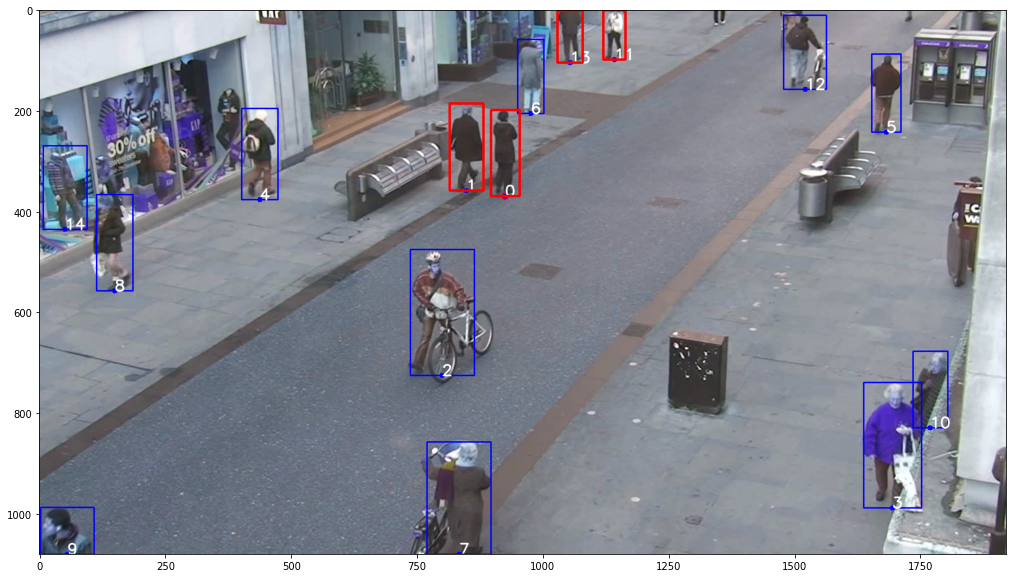

In [98]:
img = risky(img, person, p1, p2)

plt.figure(figsize=(20,10))
plt.imshow(img)

In [0]:
# Carrying out the above operations on all frames of the video.

import os     #for OS functionality
import re     #for RegExp

names = os.listdir('frames/')
names.sort(key=lambda f: int(re.sub('\D', '', f)))

In [0]:
# Function that unites every functionality we performed so far.

def find_closest_ppl(name, thresh):
  img = cv2.imread('frames/'+name)
  outputs = predictor(img)
  classes = outputs['instances'].pred_classes.cpu().numpy()
  bbox = outputs['instances'].pred_boxes.tensor.cpu().numpy()
  ind = np.where(classes==0)[0]
  person = bbox[ind]
  midpoints = [mid_cal(img, person, i) for i in range(len(person))]
  num = len(midpoints)
  dist = compute_distance(midpoints,num)
  p1, p2, d = find_closest(dist,num,thresh)
  img = risky(img, person, p1, p2)
  cv2.imwrite('frames/'+name,img)

  return 0

In [101]:
from tqdm import tqdm         #For tracking the progress frame-by-frame in real-time
thresh = 100
_=[find_closest_ppl(names[i], thresh) for i in tqdm(range(len(names)))]



  0%|          | 0/750 [00:00<?, ?it/s]

  0%|          | 1/750 [00:01<15:39,  1.25s/it]

  0%|          | 2/750 [00:02<15:13,  1.22s/it]

  0%|          | 3/750 [00:03<14:47,  1.19s/it]

  1%|          | 4/750 [00:04<14:28,  1.16s/it]

  1%|          | 5/750 [00:05<14:14,  1.15s/it]

  1%|          | 6/750 [00:06<14:02,  1.13s/it]

  1%|          | 7/750 [00:07<13:50,  1.12s/it]

  1%|          | 8/750 [00:09<13:43,  1.11s/it]

  1%|          | 9/750 [00:10<13:38,  1.10s/it]

  1%|▏         | 10/750 [00:11<13:34,  1.10s/it]

  1%|▏         | 11/750 [00:12<13:34,  1.10s/it]

  2%|▏         | 12/750 [00:13<13:27,  1.09s/it]

  2%|▏         | 13/750 [00:14<13:27,  1.10s/it]

  2%|▏         | 14/750 [00:15<13:26,  1.10s/it]

  2%|▏         | 15/750 [00:16<13:23,  1.09s/it]

  2%|▏         | 16/750 [00:17<13:22,  1.09s/it]

  2%|▏         | 17/750 [00:18<13:23,  1.10s/it]

  2%|▏         | 18/750 [00:19<13:22,  1.10s/it]

  3%|▎         | 19/750 [00:21<13:22,  1.10s/it]

  3%|▎         |

In [102]:
# Converting frames back to a video.

%%time
frames = os.listdir('frames/')
frames.sort(key=lambda f: int(re.sub('\D', '', f)))

frame_array=[]

for i in range(len(frames)):

  #Reading each file
  img = cv2.imread('frames/'+frames[i])
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

  height, width, layers = img.shape
  size = (width,height)

  #inserting the image into a frame array
  frame_array.append(img)

out = cv2.VideoWriter('sample_output.mp4', cv2.VideoWriter_fourcc(*'DIVX'), 25, size)

for i in range(len(frames)):
  #writing to an image array
  out.write(frame_array[i])
out.release()

CPU times: user 48.6 s, sys: 3.73 s, total: 52.3 s
Wall time: 51.3 s
Compiler : 120 ms
